In [1]:
import os
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorboard.backend.event_processing import event_accumulator

{'accelerator': 'gpu', 'devices': [1], 'num_workers': 0, 'seed': 1111, 'exptag': '', 'gradual_percent': 1.0, 'exptype': 'feedforwardmask_synthetic_continual_er_1111_1.0', 'model_path': '', 'checkpt': '', 'save_files': True, 'model': 'feedforwardmask', 'stochastic': True, 'meta': True, 'dataset': 'synthetic', 'dataset_ver': 'scar_', 'task_ids': [13, 16, 3, 0, 2, 5, 1, 7, 15], 'data_names': ['AW', 'DC', 'EC'], 'signal_type': 'egm', 'seq_len': 101, 'graph_method': 'bipartite', 'load_torso': 0, 'load_physics': 0, 'signal_source': 'heart', 'omit': 5, 'window': 60, 'task_setting': 'continual', 'num_updates_steps': 2000, 'num_task_steps': 2050, 'log_interval': 50, 'val_log_interval': 50, 'memory_name': 'er', 'known_boundary': True, 'boundary_detection': False, 'latent_dim': 64, 'latent_act': 'swish', 'num_layers': 1, 'num_hidden': 64, 'code_dim': 12, 'num_filters': [1, 8, 16, 32, 64, 128, 256], 'metrics': ['mse', 'tcc', 'scc'], 'batch_size': 10, 'domain_size': 5, 'domain_varying': True, 'grad

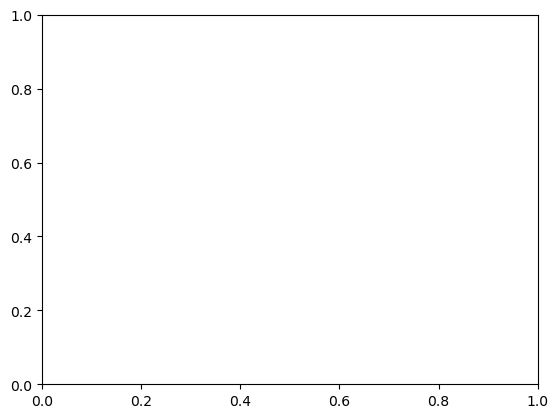

In [2]:
# Model to plot
model_dir = "/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_er_1111_1.0/feedforwardmask/version_0"
model = model_dir.split("/")[3]
memory = model_dir.split("/")[2].split("_")[-1]
cfg_dir = f"{model_dir}/task_0/hparams.yaml"

with open(cfg_dir, 'r') as stream:
    cfg = yaml.safe_load(stream)
print(cfg)

# Make a consistent color theme across dynamic groups
colors = []
current_color = None
for task_id in range(25):
    if task_id % 3 == 0:
        current_color = next(plt.gca()._get_lines.prop_cycler)['color']

    colors.append(current_color)
print(f"=> Sequence of Colors: {colors}")

In [3]:
def get_metrics_dict(model_dir):
    model = model_dir.split("/")[3]
    memory = model_dir.split("/")[2].split("_")[-1]
    cfg_dir = f"{model_dir}/task_0/hparams.yaml"

    with open(cfg_dir, 'r') as stream:
        cfg = yaml.safe_load(stream)

    # Get the performance metrics across tasks
    task_performances = dict()
    for task_id in range(len(cfg['task_ids'])):
        task_performances[f"task_{task_id}"] = dict()
        for metric in cfg['metrics']:
            task_performances[f"task_{task_id}"][f'{metric}_mean'] = [np.nan for _ in range(len(cfg['task_ids']))]
            task_performances[f"task_{task_id}"][f'{metric}_std'] = [np.nan for _ in range(len(cfg['task_ids']))]

    for idx in range(len(cfg['task_ids'])):
        for task_idx in range(len(cfg['task_ids'][:idx + 1])):
            try:
                task_metrics = json.load(
                    open(f"{model_dir}/task_{idx}/test_{task_idx}/test_{task_idx}_metrics.json")
                )

                for metric in cfg['metrics']:
                    task_performances[f"task_{task_idx}"][f'{metric}_mean'][idx] = task_metrics[f'{metric}_mean']
                    task_performances[f"task_{task_idx}"][f'{metric}_std'][idx] = task_metrics[f'{metric}_std']

            except Exception as e:
                print(e)
                continue

    return task_performances

In [4]:
dataset = "mp"
base_path = f"mixed-physics/"

metrics = dict()
for model_name, model_path in zip(["Reservoir-Sampling", "Naive"], ["/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_task_aware_1111_1.0/feedforwardmask/version_0", 
                                                              "/home/rxm7244/Projects/CoSFan-NeuralSurrogate/experiments/feedforwardmask_synthetic_continual_naive_1111_1.0/feedforwardmask/version_0"]):
    metrics[model_name] = get_metrics_dict(model_path)


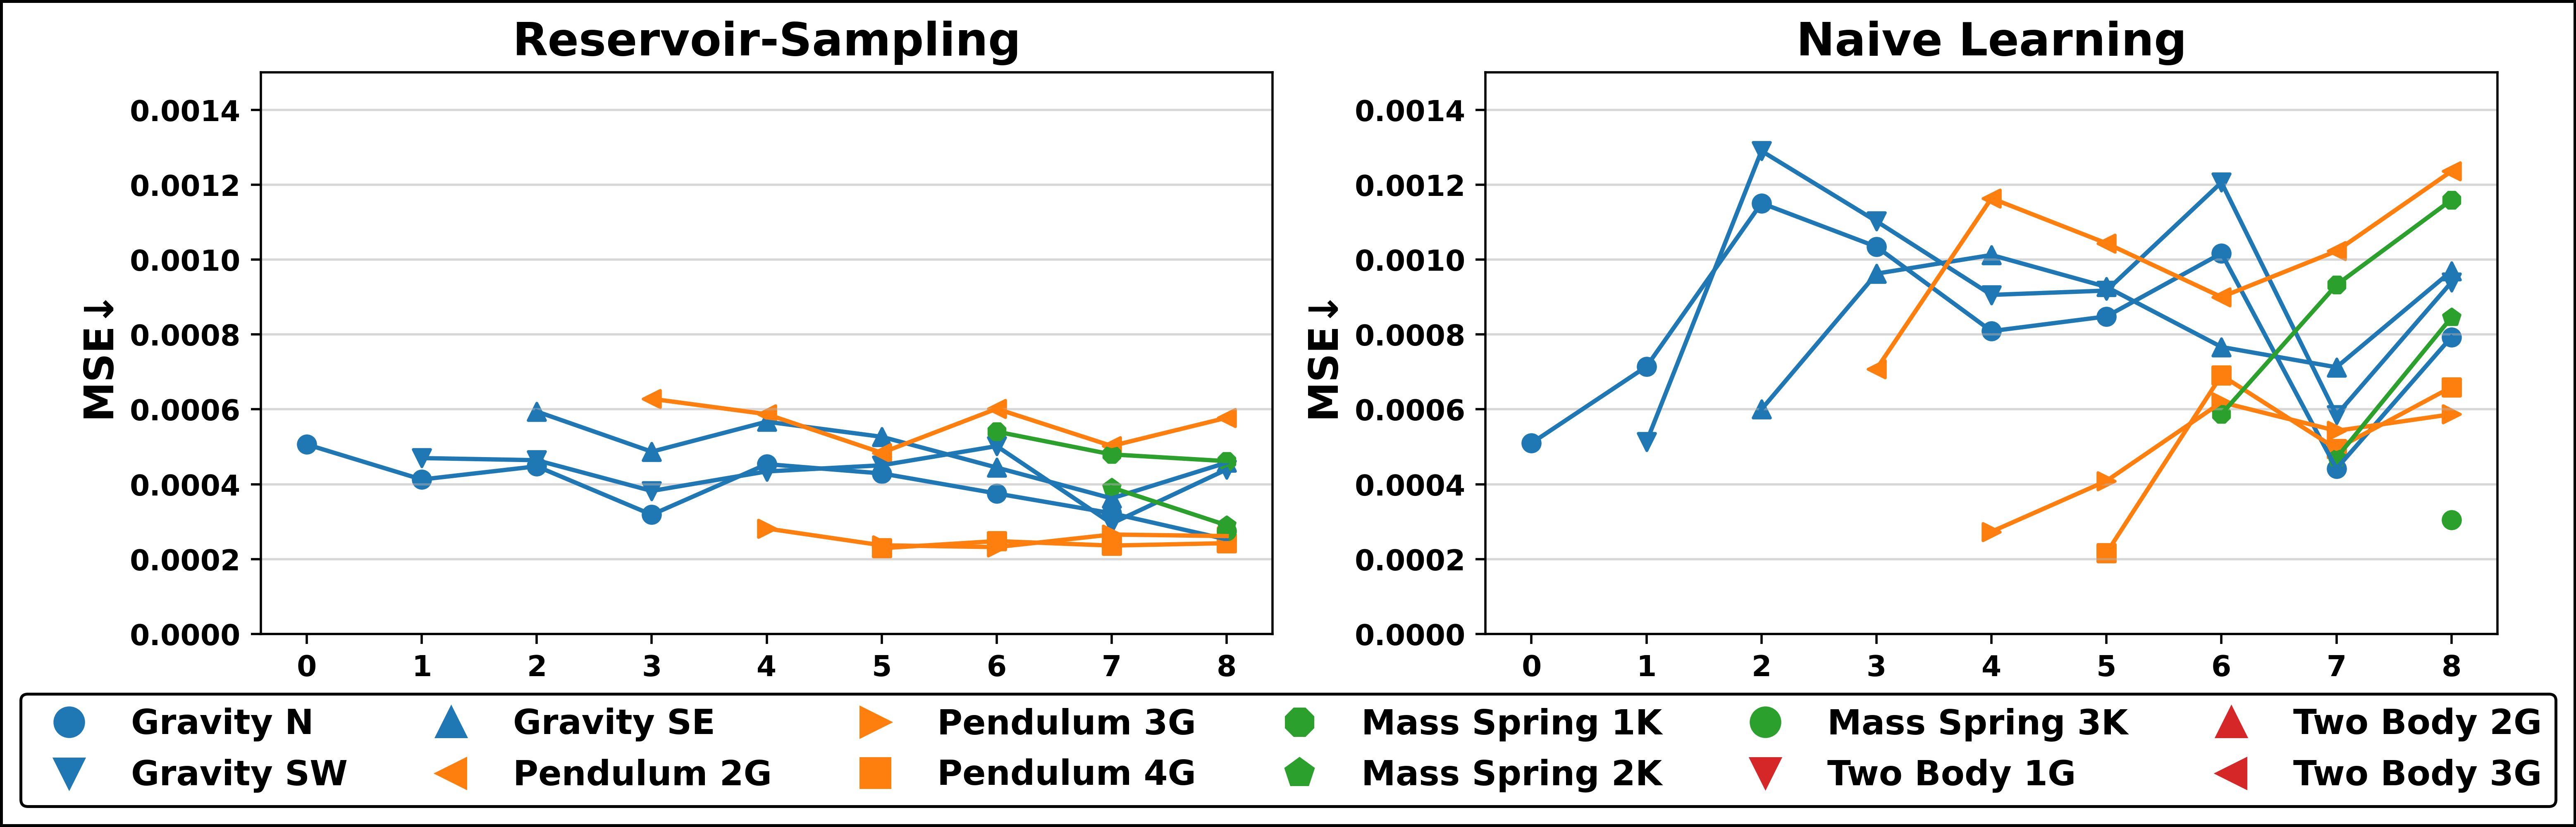

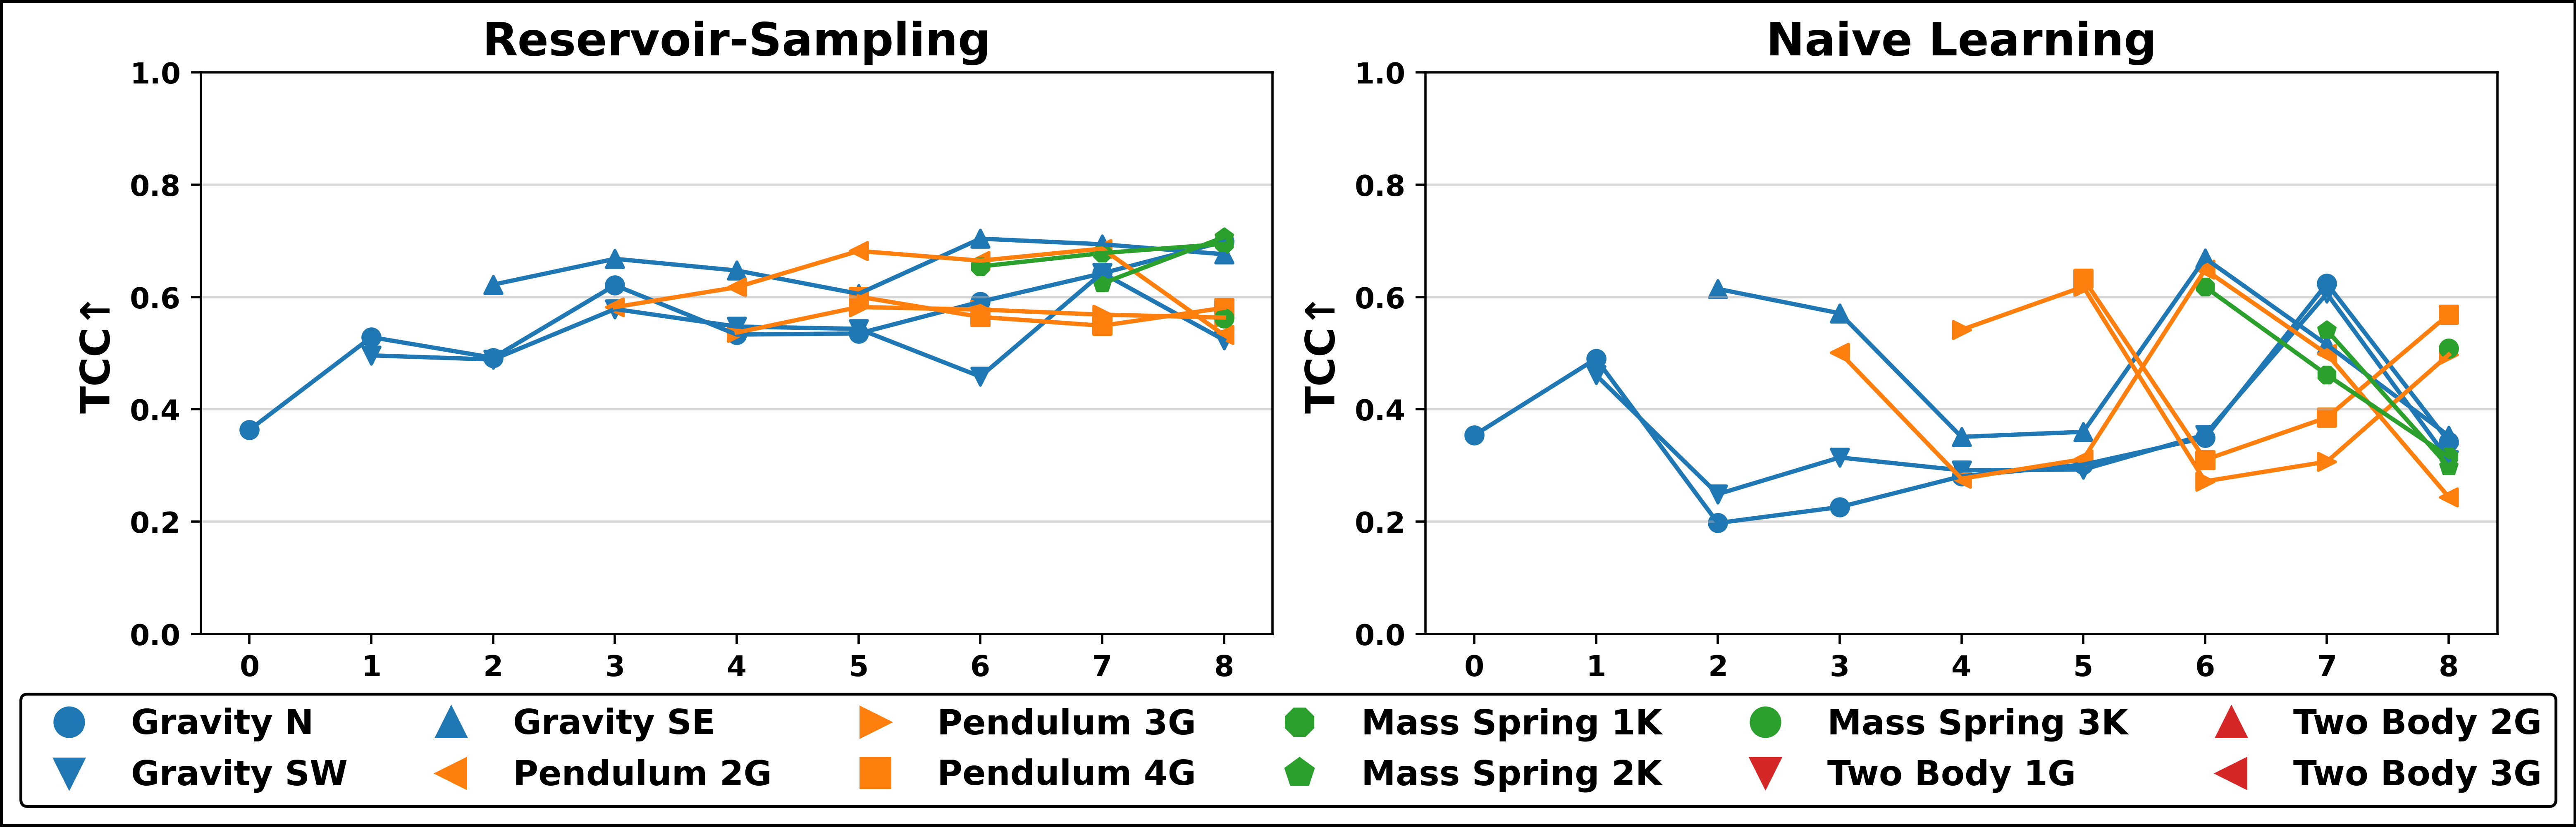

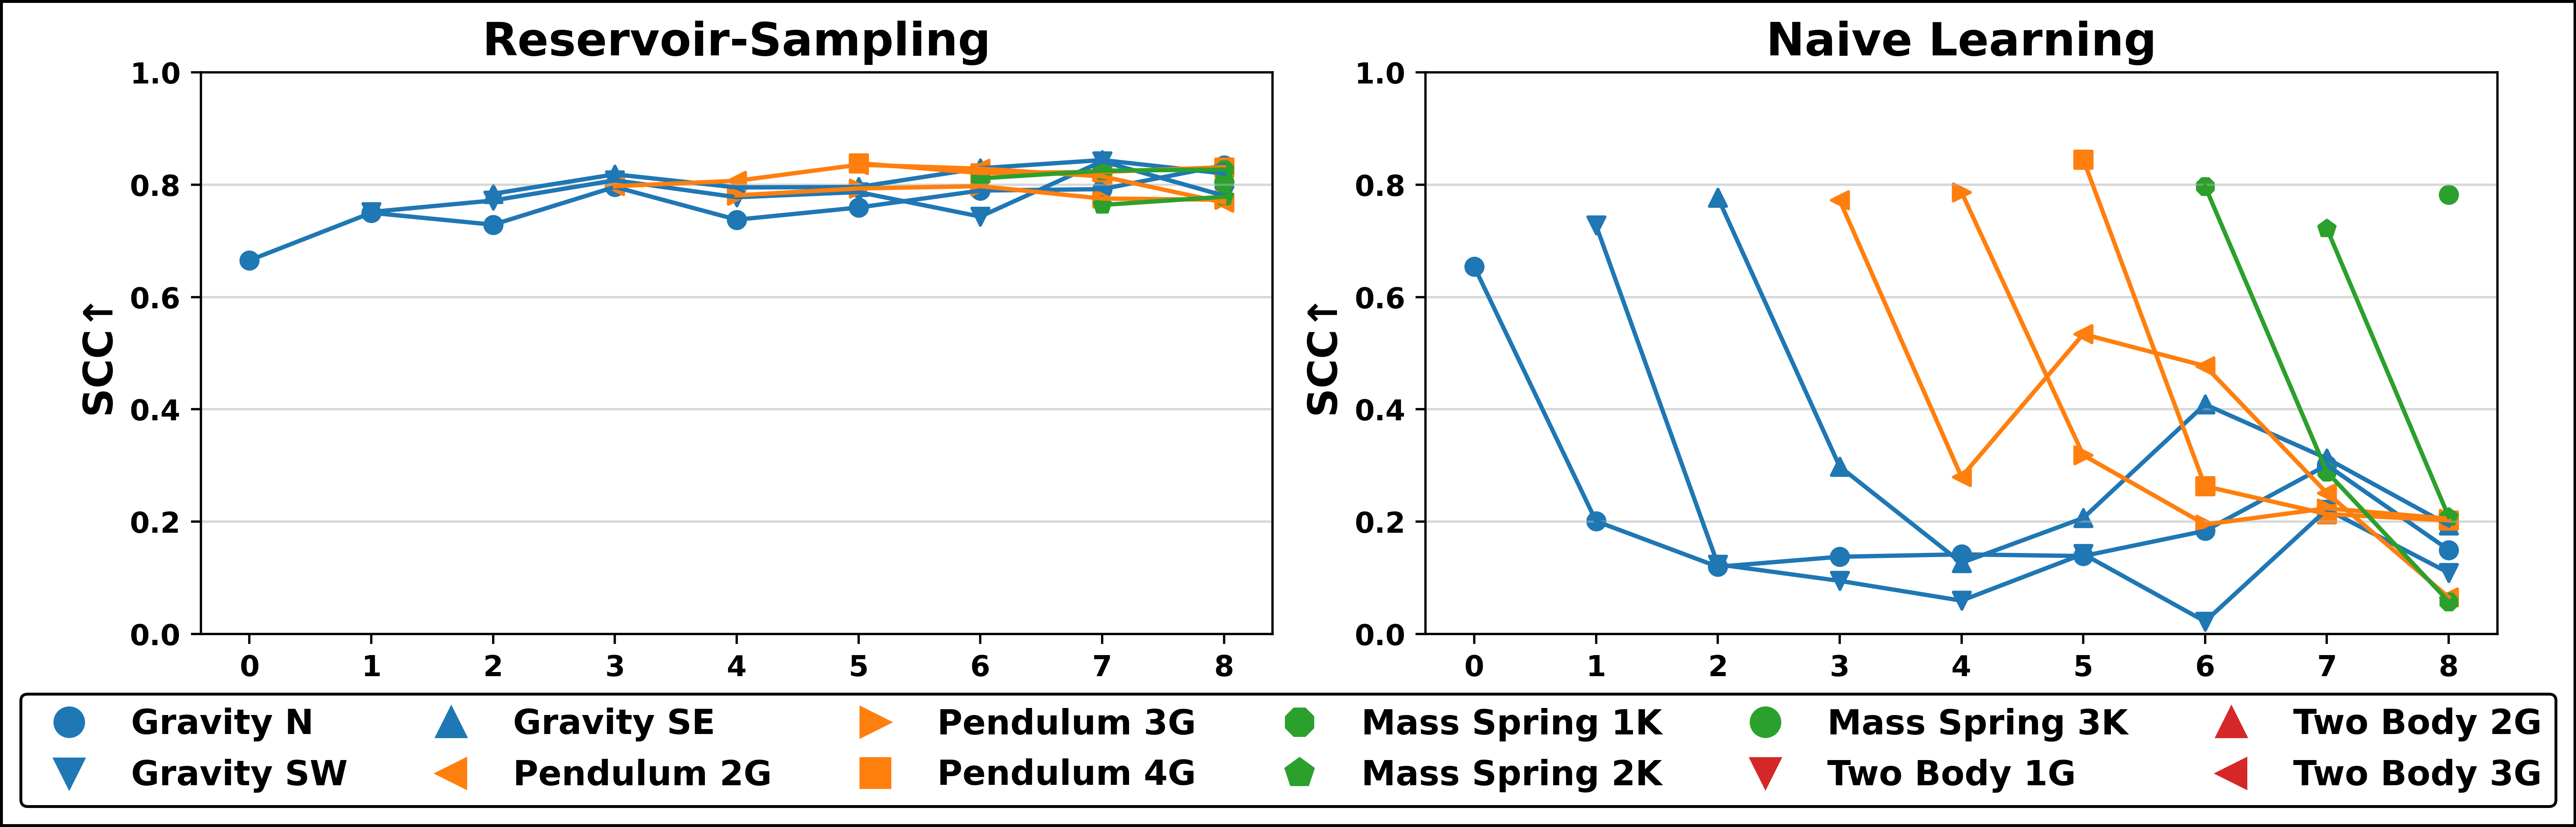

In [6]:
import matplotlib.pyplot as plt
import numpy as np

params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

metrics_to_plot = ['mse_mean', 'tcc_mean', 'scc_mean']
ylim_dict = {
    'mse_mean': (0, 0.0015),
    'tcc_mean': (0, 1.0),
    'scc_mean': (0, 1.0)
}
ylabel_dict = {
    'mse_mean': 'MSE↓',
    'tcc_mean': 'TCC↑',
    'scc_mean': 'SCC↑'
}

for metric in metrics_to_plot:
    # Create a figure with 2 subplots, sharing the same x-axis
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), dpi=500, sharex=True)
    
    # Set a common font size for readability in a scientific paper
    label_font_size = 14
    title_font_size = 16
    legend_font_size = 12
    markers = ['o', 'v', '^', '<', '>', 's', '8', 'p', 'o', 'v', '^', '<', '>', 's', '8', 'p']

    # Plot Cluster
    for task_id in range(len(cfg['task_ids'])):
        task_id = int(task_id)
        axes[0].plot(range(len(cfg['task_ids'])), metrics["Reservoir-Sampling"][f"task_{task_id}"][metric], label=f"task_{task_id}", color=colors[task_id])
        axes[0].scatter(range(len(cfg['task_ids'])), metrics["Reservoir-Sampling"][f"task_{task_id}"][metric], marker=markers[task_id], c=colors[task_id])

    axes[0].set_title('Reservoir-Sampling', fontsize=title_font_size, fontweight='bold')
    axes[0].set_ylabel(ylabel_dict[metric], fontsize=label_font_size, fontweight='bold')
    axes[0].set_xticks(range(len(cfg['task_ids'])))
    axes[0].set_ylim(*ylim_dict[metric])
    axes[0].grid(True, axis='y', alpha=0.5)

    # Plot NonCluster
    for task_id in range(len(cfg['task_ids'])):
        task_id = int(task_id)
        axes[1].plot(range(len(cfg['task_ids'])), metrics["Naive"][f"task_{task_id}"][metric], label=f"task_{task_id}", color=colors[task_id])
        axes[1].scatter(range(len(cfg['task_ids'])), metrics["Naive"][f"task_{task_id}"][metric], marker=markers[task_id], c=colors[task_id])

    axes[1].set_title('Naive Learning', fontsize=title_font_size, fontweight='bold')
    axes[1].set_ylabel(ylabel_dict[metric], fontsize=label_font_size, fontweight='bold')
    axes[1].set_xticks(range(len(cfg['task_ids'])))
    axes[1].set_ylim(*ylim_dict[metric])
    axes[1].grid(True, axis='y', alpha=0.5)

    # Create legend
    import matplotlib.lines as mlines
    bb_patch1 = mlines.Line2D([], [], marker=markers[0], linestyle='None', markersize=10, color=colors[0], label='Gravity N')
    bb_patch2 = mlines.Line2D([], [], marker=markers[1], linestyle='None', markersize=10, color=colors[0], label='Gravity SW')
    bb_patch3 = mlines.Line2D([], [], marker=markers[2], linestyle='None', markersize=10, color=colors[0], label='Gravity SE')
    pd_patch1 = mlines.Line2D([], [], marker=markers[3], linestyle='None', markersize=10, color=colors[3], label='Pendulum 2G')
    pd_patch2 = mlines.Line2D([], [], marker=markers[4], linestyle='None', markersize=10, color=colors[3], label='Pendulum 3G')
    pd_patch3 = mlines.Line2D([], [], marker=markers[5], linestyle='None', markersize=10, color=colors[3], label='Pendulum 4G')
    dp_patch1 = mlines.Line2D([], [], marker=markers[6], linestyle='None', markersize=10, color=colors[6], label='Mass Spring 1K')
    dp_patch2 = mlines.Line2D([], [], marker=markers[7], linestyle='None', markersize=10, color=colors[6], label='Mass Spring 2K')
    dp_patch3 = mlines.Line2D([], [], marker=markers[8], linestyle='None', markersize=10, color=colors[6], label='Mass Spring 3K')
    tb_patch1 = mlines.Line2D([], [], marker=markers[9], linestyle='None', markersize=10, color=colors[9], label='Two Body 1G')
    tb_patch2 = mlines.Line2D([], [], marker=markers[10], linestyle='None', markersize=10, color=colors[9], label='Two Body 2G')
    tb_patch3 = mlines.Line2D([], [], marker=markers[11], linestyle='None', markersize=10, color=colors[9], label='Two Body 3G')
    
    handles = [bb_patch1, bb_patch2, bb_patch3, pd_patch1, pd_patch2, pd_patch3, dp_patch1, dp_patch2, dp_patch3, tb_patch1, tb_patch2, tb_patch3]
    labels = ['Gravity N', 'Gravity SW', 'Gravity SE', 'Pendulum 2G', 'Pendulum 3G', 'Pendulum 4G', 'Mass Spring 1K', 'Mass Spring 2K', 'Mass Spring 3K', 'Two Body 1G', 'Two Body 2G', 'Two Body 3G']
    legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=6, fontsize=legend_font_size, frameon=True)

    # Customize legend
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_alpha(1)

    plt.tight_layout()

    fig.patch.set_linewidth(2)
    fig.patch.set_edgecolor('black')

    # Save and show the plot
    plt.savefig(f"figure_naivecomparison_{metric}.svg", bbox_inches="tight")
    plt.savefig(f"figure_naivecomparison_{metric}.png", bbox_inches="tight")
    plt.show()
    plt.close()